# Lab 1: Decision trees Regression and Bagging
### Univ.AI
### ML-2 Cohort-1


The goal of this lab is to predict the winner of the 2016 Presidential election (Trump vs. Clinton) in each county in the US, measured as 'votergap' = (trump - clinton) in percentage points. <br>
We do already know the answer to this now in 2021, but we intend to make a model to see how right or wrong our predictions are!

To do this, we consider several predictors and model a decision tree to perform regression and predict the dependent variable 'votergap'.
We then try to improve upon our simple Decision Tree model by implementing bagging.

In [175]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import r2_score
plt.style.use('seaborn-dark')

## Part 1:  Reading and Exploring the data

We will be using 'county_level_election.csv' to model the outcome of the 2016 presidential election from various predictors.

We start by reading in the datasets and visualizing the main predictors for now.

In [176]:
#your code here
df = pd.read_csv('data/county_level_election.csv')

In [177]:
df

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,Virginia,51103,Lancaster County,11230,1.824,30.059,53.142,6.7,45827,12.0,28.7,25.0,29.8,85.5,425.4,9.971,53.341,43.370
3062,Florida,12125,Union County,14584,5.711,25.791,34.882,4.8,40207,25.2,8.6,31.1,37.1,63.8,427.8,62.410,80.221,17.811
3063,North Dakota,38041,Hettinger County,2343,2.737,6.065,51.775,2.4,50038,12.6,16.0,26.9,29.1,3.4,433.9,68.517,81.840,13.323
3064,Nevada,32011,Eureka County,1707,14.038,8.631,46.875,6.0,70535,11.3,22.9,21.2,27.2,0.2,445.4,75.995,84.660,8.665


Perform an 80-20 train-test split on the dataframe to get your training and test data. Take only the following features in 'X': 'population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer'

In [178]:
#Split 80/20 train-test
X = df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
y = df['votergap']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)
#your code here

In [179]:
y_train

1374    42.131
351     -2.350
2923    46.154
1195    19.278
2585    16.675
         ...  
1638    22.960
1095    47.203
1130    33.590
1294    -0.209
860     56.675
Name: votergap, Length: 2452, dtype: float64

Consider 1 variable, say minority, and plot the relationship between minority and the dependent variable.

Also plot this on a log scale to see if we can visualize it easier.


Note: We chose minority as it has the highest correlation with our target variable, you can also see this by printing out the correlation matrix using `sns.heatmap()` <br>
Remember not to leak any data while calculating the correlation!

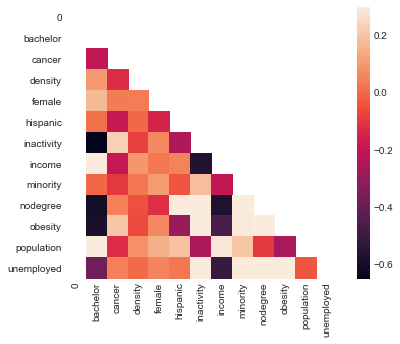

In [180]:
df_corr = pd.concat([X_train, y_train])
corr = df_corr.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

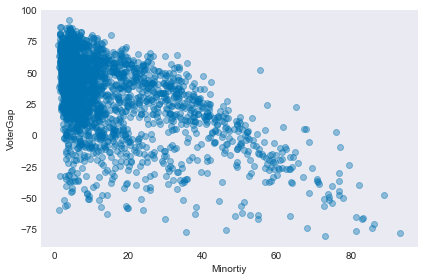

In [181]:
#Plot minorty vs votergap
#your code here
plt.scatter(X_train['minority'], y_train, alpha=0.4)
plt.xlabel('Minortiy')
plt.ylabel('VoterGap')
plt.tight_layout()

In [182]:
plt.style.use('seaborn-dark')

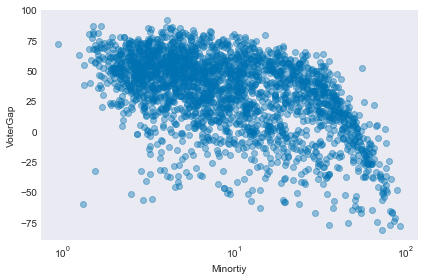

In [183]:
#Plot log(minorty) vs votergap
#your code here
plt.scatter(X_train['minority'], y_train, alpha=0.4)
plt.xlabel('Minortiy')
plt.xscale('log')
plt.ylabel('VoterGap')
plt.tight_layout()
plt.style.use('seaborn-colorblind')

## Part 2: Decision Trees

### 2.1: Fitting with 1 predictor

First, let us fit, visualize, and interpret a tree with 1 predictor - minority.

You will need to build a Decisition tree Regressor and plot their predictions of the training data with the actual train data as seen below.
![goodreadsexample](https://drive.google.com/uc?export=view&id=1iTuS6SdohXYSzGm8hJYf1m4W3en0hIOt)


As you can see from above, we have tried out various max_depth and min_samples_split. <br>
Feel free to play around with sklearns DecisionTreeRegressor functions parameters.

In [184]:
#your code here
X_train_1p = X_train[['minority']]
X_test_1p = X_test[['minority']]

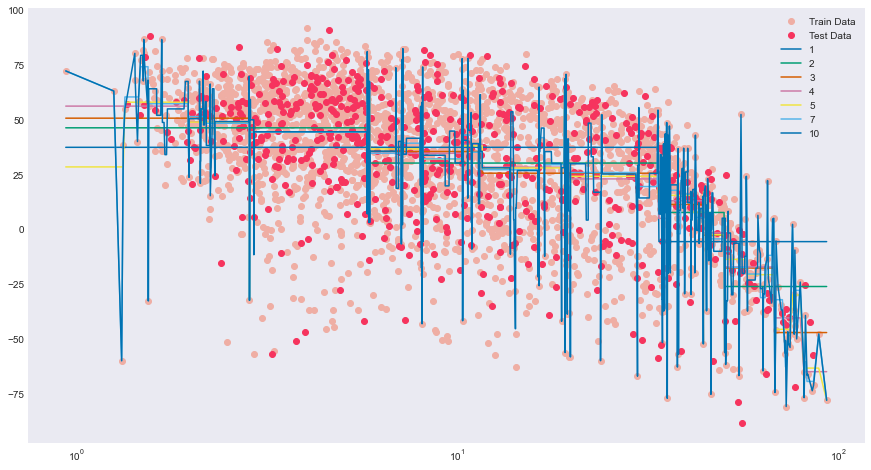

In [185]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(15,8))
train_mse=[]
test_mse=[]

plt.plot(X_train_1p,y_train,'o',color='#EFAEA4', markersize=6, label="Train Data")
plt.plot(X_test_1p,y_test,'o',color='#F6345E', markersize=6, label="Test Data")
plt.xscale('log')
depths=[1,2,3,4,5,7,10]
for i in depths:
    dtsin = DecisionTreeRegressor(max_depth=i)
    dtsin.fit(X_train[['minority']], y_train)
    sort_x_train, sort_y_predtrain = zip(*sorted(zip( X_train['minority'], dtsin.predict( X_train[['minority']]))))
    plt.plot(sort_x_train,sort_y_predtrain, label=i)
    train_mse.append(mean_squared_error(y_train, dtsin.predict(X_train[['minority']]) ))
    test_mse.append(mean_squared_error(y_test, dtsin.predict(X_test[['minority']])))
plt.legend();

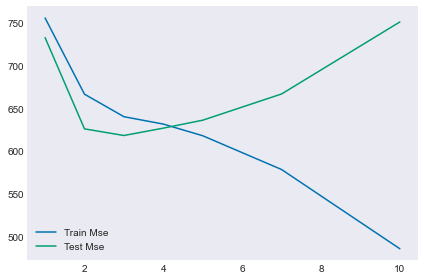

In [186]:
plt.plot(depths, train_mse, label='Train Mse')
plt.plot(depths, test_mse, label='Test Mse')
plt.legend()
plt.tight_layout()

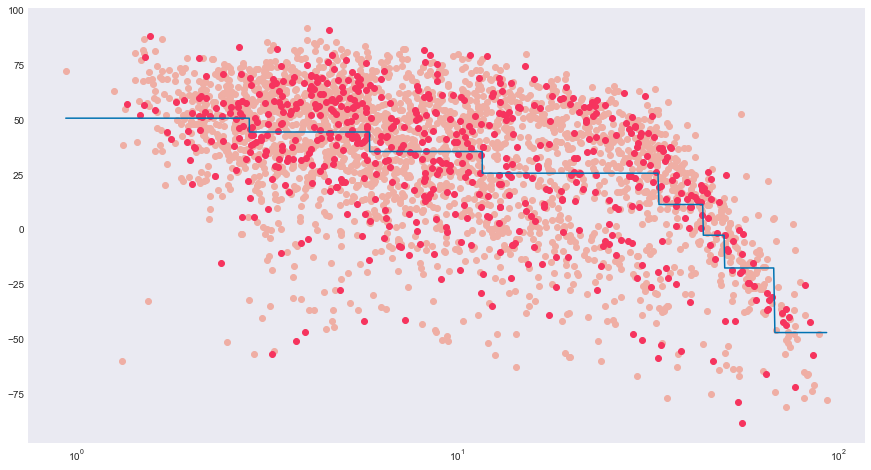

In [187]:
#plotting for beest depth 
plt.figure(figsize=(15,8))
train_mse=[]
test_mse=[]

plt.plot(X_train_1p,y_train,'o',color='#EFAEA4', markersize=6, label="Train Data")
plt.plot(X_test_1p,y_test,'o',color='#F6345E', markersize=6, label="Test Data")
plt.xscale('log')
depths=[3]
for i in depths:
    dtsin = DecisionTreeRegressor(max_depth=i)
    dtsin.fit(X_train[['minority']], y_train)
    sort_x_train, sort_y_predtrain = zip(*sorted(zip( X_train['minority'], dtsin.predict( X_train[['minority']]))))
    plt.plot(sort_x_train,sort_y_predtrain, label=i)

### 2.2: Fitting with all predictors

Now, use all the predictors to model the Decision Tree.

Print out the actual training set and their predictions and compare these values to see how well your model has done. Save this as a dataframe.

In [188]:
#your code here

train_mse=[]
test_mse=[]
depths=[1,2,3,4,5,7,10,12,14,16]
#depths=[10]
for i in depths:
    dtsin = DecisionTreeRegressor(max_depth=i)
    dtsin.fit(X_train, y_train)
    sort_x_train, sort_y_predtrain = zip(*sorted(zip( X_train, dtsin.predict( X_train))))
    train_mse.append(mean_squared_error(y_train, dtsin.predict(X_train) ))
    test_mse.append(mean_squared_error(y_test, dtsin.predict(X_test)))

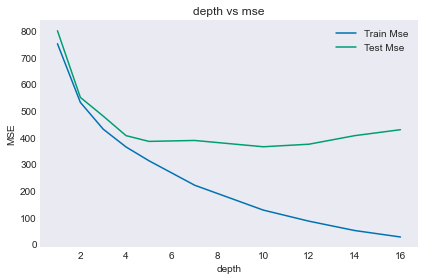

In [192]:
plt.plot(depths, train_mse, label='Train Mse')
plt.plot(depths, test_mse, label='Test Mse')
plt.xlabel('depth')
plt.ylabel('MSE')
plt.title('depth vs mse')
plt.legend()
plt.tight_layout()

In [193]:
best_mse_index = test_mse.index(min(test_mse))
best_depth = depths[best_mse_index]
best_depth

10

Perform 5-fold cross-validation to determine what the best max_depth would be for a single regression tree using your entire training set and GridSearchCV().

Next, visualize these results by plotting the mean CV score and +/- 2 standard deviations across the validation sets.<br>
To do this, you will need to store the training scores, mean and standard deviations of the test score.

Your plot should look something like this: 

![goodreadsexample](https://drive.google.com/uc?export=view&id=1iAJf3AGbiri8r6B0nrtbRIgxhkF1yGsR)


In [194]:
dtree_reg = DecisionTreeRegressor(max_depth = 2)
cv_score = cross_val_score(dtree_reg, X_train, y_train, scoring='neg_mean_squared_error')
print(cv_score.mean())

-552.7690191166832


In [195]:
depths = list(range(1, 21))
#https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
#your code here
def cross_val_on_trees(X_train, y_train, depths, cv=5, scoring='neg_mean_squared_error'):
    cv_score_list= []
    cv_score_std = []
    cv_score_mean= []
    accuracy_scores = []
    train_mse = []
    for depth in depths:
        dtree = DecisionTreeRegressor(max_depth= depth)
        cv_scores = cross_val_score(dtree,X_train, y_train, cv=cv, scoring=scoring)
        cv_score_list.append(cv_scores)
        cv_score_mean.append(cv_scores.mean())
        cv_score_std.append(cv_scores.std())
        dtree.fit(X_train, y_train)
        train_mse.append(-1 * (mean_squared_error(y_train, dtree.predict(X_train))))
        
    cv_score_mean = np.array(cv_score_mean)
    cv_score_std = np.array(cv_score_std)
    train_mse = np.array(train_mse)
    return cv_score_mean,cv_score_std, train_mse 

def plt_cross_val_tress(depths, cv_score_mean, cv_score_std, train_mse, title):
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    ax.plot(depths, cv_score_mean, '-o', label='mean cross-validation loss', alpha=0.9)
    ax.fill_between(depths, cv_score_mean-2*cv_score_std, cv_score_mean+2*cv_score_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, train_mse, '-*', label='train_mse', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Neg mean Square Error', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

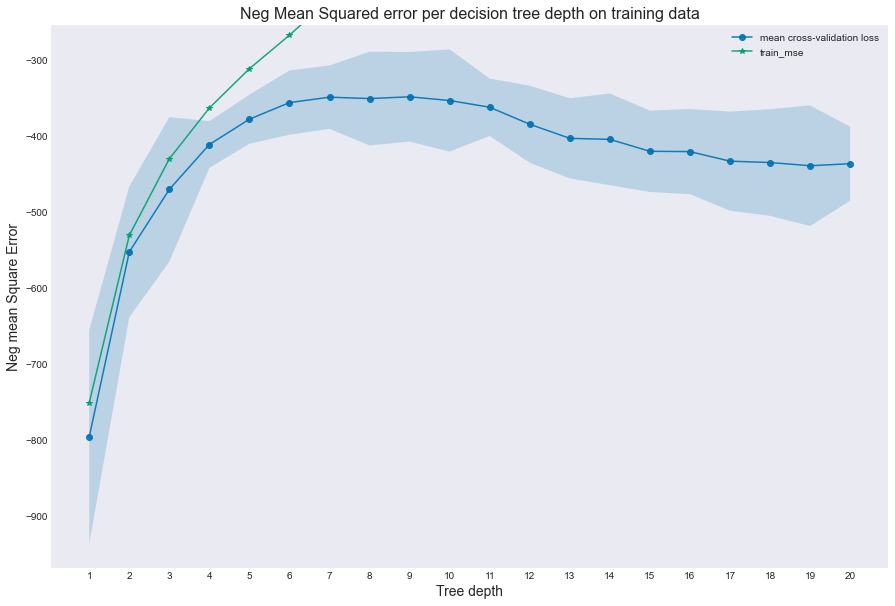

In [196]:
sm_cv_scores_mean, sm_cv_scores_std, sm_train_mse = cross_val_on_trees(X_train, y_train, depths)

# plotting accuracy
plt_cross_val_tress(depths, sm_cv_scores_mean, sm_cv_scores_std, sm_train_mse, 'Neg Mean Squared error per decision tree depth on training data')

    
 


In [197]:
def best_tree(tree, parameter, X, y, n_folds=5):
    gs = GridSearchCV(tree, param_grid=parameter, cv=n_folds)
    gs.fit(X,y)
    print('Best', gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best 

In [198]:
depths = {'max_depth' : list(range(1, 21))}
dtree = DecisionTreeRegressor()
best = best_tree(dtree, depths, X_train, y_train, n_folds=5)

Best {'max_depth': 9} 0.6350117234227355


Choose the best max_depth based on the result of your cross validation and build your final model with all predictors and the optimal max_depth.<br>
Also print out the mean accuracy on the train and test data using the `score()` method from the DecisionTreeRegressor class.

**You can add pruning or any other techniques you have learnt in the lectures till now.**

In [199]:
#your code here

dtsin = best
dtsin.fit(X_train, y_train)
sort_x_train, sort_y_predtrain = zip(*sorted(zip( X_train, dtsin.predict( X_train))))


print("Train accuracy:", mean_squared_error(y_train, dtsin.predict(X_train)))
print("Test accuracy:", mean_squared_error(y_test, dtsin.predict(X_test)))

Train accuracy: 152.91776113236168
Test accuracy: 365.63726964362604


In [200]:
path = dtsin.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
dtree_models = []
train_mse = []
test_mse = []
for ccp_alpha in ccp_alphas:
    dtree = DecisionTreeRegressor(ccp_alpha= ccp_alpha)
    dtree.fit(X_train, y_train)
    dtree_models.append(dtree)
    test_mse.append(mean_squared_error(y_test, dtree.predict(X_test)))
    train_mse.append(mean_squared_error(y_train, dtree.predict(X_train)))

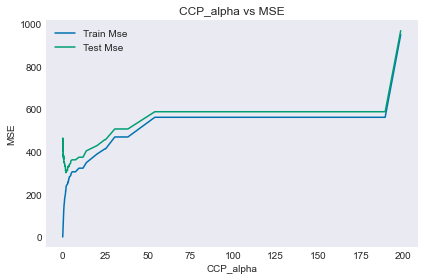

In [201]:
plt.plot(ccp_alphas, train_mse, label='Train Mse')
plt.plot(ccp_alphas, test_mse, label='Test Mse')
plt.legend()
plt.xlabel('CCP_alpha')
plt.ylabel('MSE')
plt.title('CCP_alpha vs MSE')
plt.tight_layout()

In [202]:
index_best_model = test_mse.index(min(test_mse))
best_model = dtree_models[index_best_model]
best_ccp_alpha = ccp_alphas[index_best_model]
print('best value of alpha is',best_ccp_alpha)

best value of alpha is 1.817700067159055


In [203]:
# final model 
dtree = DecisionTreeRegressor(max_depth =9, ccp_alpha= best_ccp_alpha)
dtree.fit(X_train, y_train)
dtree_models.append(dtree)
print('Test MSE:',mean_squared_error(y_test, dtree.predict(X_test)))
print('Train MSE:',mean_squared_error(y_train, dtree.predict(X_train)))

Test MSE: 308.0076973395258
Train MSE: 233.835645838033


## Part 3: Bagging

You might still be overfitting in your previous model, we can now attempt to reduce the overfitting by implementing bagging. <br>
In this lab, we will be performing bagging for a decision tree modeled only on a single predictor as it is easier to visualize.

To do this, you will need to first bootstrap (resample data) and aggregate over all of the bootstrapped models. <br>
Plot your bagged models predictions in the training set along with the actual full training set to observe the predictions of your bagged models. <br>

Try implementing this without using sklearns `BaggingRegressor()`!

### 3.1: Bagging with 1 predictor

In [250]:
#your code here
from sklearn.ensemble import BaggingRegressor
bagging_1p = BaggingRegressor(n_estimators=100,base_estimator=DecisionTreeRegressor(max_depth=3), n_jobs=-1)
bagging_1p.fit(X_train[['minority']], y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                 n_estimators=100, n_jobs=-1)

In [251]:
y_train.shape
y_train_pred = bagging_1p.predict(X_train[['minority']]).reshape(1,-1)

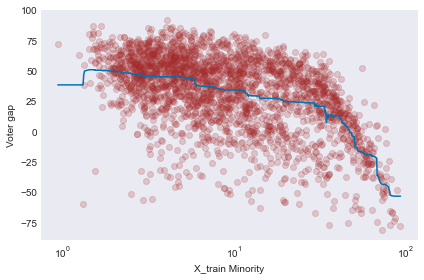

In [252]:
#Plot the actual train data vs your bagged models predictions on the train data
plt.scatter(X_train[['minority']], y_train,alpha=0.2, color='brown', label='Train Data')
sort_x_train, sort_y_predtrain = zip(*sorted(zip( X_train['minority'], bagging_1p.predict( X_train[['minority']]))))
sort_x_test, sort_y_predtest = zip(*sorted(zip( X_test['minority'], bagging_1p.predict( X_test[['minority']]))))
plt.plot(sort_x_train, sort_y_predtrain, label ='Train Pred data')
plt.xscale('log')
plt.xlabel('X_train Minority')
plt.ylabel('Voter gap')
plt.tight_layout()

### 3.2: Bagging with all predictors

Perform the same operations as you did above, except this time with all the predictors. 
In addition to this, calculate the average score of all of the individual trees and plot a histogram of the same. <br>
![goodreadsexample](https://drive.google.com/uc?export=view&id=1qBk8TMOygnIDmUCSzpkrrH7N0ulOrHSr)



Also print and calculate the score of the aggregated trees.

You need not plot the training set and their predictions as it gets harder to visualize so many dimensions.

In [246]:
#your code here
bagging = BaggingRegressor(n_estimators=100,base_estimator=DecisionTreeRegressor(max_depth=9, ccp_alpha= best_ccp_alpha), n_jobs=-1)
bagging.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=1.817700067159055,
                                                      max_depth=9),
                 n_estimators=100, n_jobs=-1)

In [261]:
mean_squared_error(y_train, bagging.predict(X_train))
mean_squared_error(y_test, bagging.predict(X_test))

248.6696843540051

In [262]:
def best_tree(tree, parameter, X, y, n_folds=5):
    gs = GridSearchCV(tree, param_grid=parameter, cv=n_folds)
    gs.fit(X,y)
    print('Best', gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best 

In [263]:
n_estimators = {'n_estimators' : list(range(1, 150))}
baggingtree = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=9, ccp_alpha= best_ccp_alpha), n_jobs=-1)
best = best_tree(baggingtree, n_estimators, X_train, y_train, n_folds=5)

Best {'n_estimators': 136} 0.7416164027581855


In [264]:
n_estimators = list(range(1, 150))
#https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
#your code here
def cross_val_on_bagging(X_train, y_train, n_estimators, cv=5, scoring='neg_mean_squared_error'):
    cv_score_list= []
    cv_score_std = []
    cv_score_mean= []
    accuracy_scores = []
    train_mse = []
    for n in n_estimators:
        baggingtree = BaggingRegressor(n_estimators=n, base_estimator=DecisionTreeRegressor(max_depth=9, ccp_alpha= best_ccp_alpha), n_jobs=-1)
        cv_scores = cross_val_score(baggingtree,X_train, y_train, cv=cv, scoring=scoring)
        cv_score_list.append(cv_scores)
        cv_score_mean.append(cv_scores.mean())
        cv_score_std.append(cv_scores.std())
        baggingtree.fit(X_train, y_train)
        train_mse.append(-1 * (mean_squared_error(y_train, baggingtree.predict(X_train))))
        
    cv_score_mean = np.array(cv_score_mean)
    cv_score_std = np.array(cv_score_std)
    train_mse = np.array(train_mse)
    return cv_score_mean,cv_score_std, train_mse 

def plt_cross_val_tress(n_estimators, cv_score_mean, cv_score_std, train_mse, title):
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    ax.plot(n_estimators, cv_score_mean, '-o', label='mean cross-validation loss', alpha=0.9)
    ax.fill_between(n_estimators, cv_score_mean-2*cv_score_std, cv_score_mean+2*cv_score_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(n_estimators, train_mse, '-*', label='train_mse', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Neg mean Square Error', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(n_estimators)
    ax.legend()

In [266]:
sm_cv_scores_mean, sm_cv_scores_std, sm_train_mse = cross_val_on_bagging(X_train, y_train, n_estimators)

# plotting accuracy


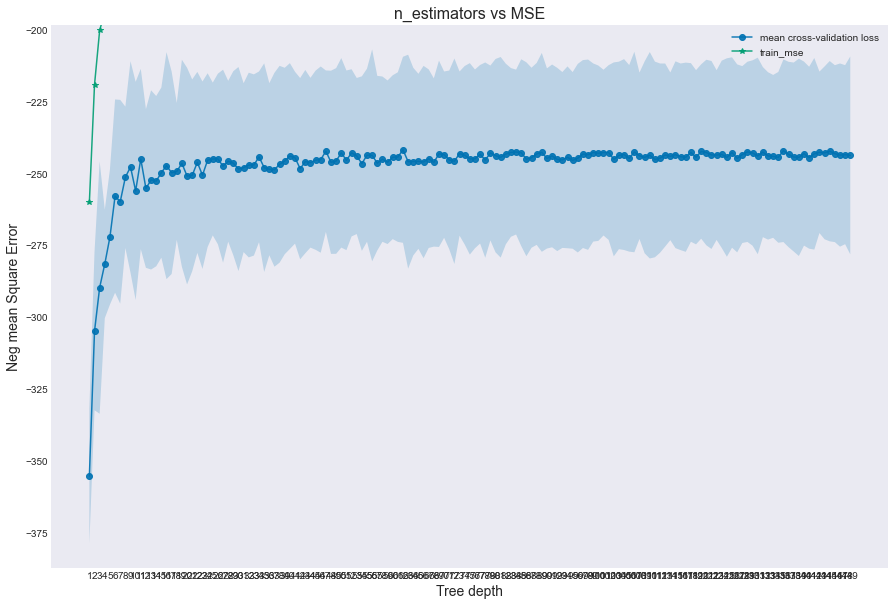

In [269]:
plt_cross_val_tress(n_estimators, sm_cv_scores_mean, sm_cv_scores_std, sm_train_mse, 'n_estimators vs MSE')

Question: What do you observe from the above histogram and the aAverage R-squared score of the individual trees and the R-squared score of the aggregated trees?

*Your answer here*